# FactoryML

## Hardware

In [10]:
!nvidia-smi

Sun May 18 16:36:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.144                Driver Version: 570.144        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P5              8W /  115W |    6259MiB /   8188MiB |     51%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports

In [11]:
import os
import pandas as pd
import numpy as np
from keras import models, layers, callbacks
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib

## Loading data

### Columns

For furnace:
- DateTime - timestamp of the data
- ActivePower - power draw of the furnace
- ReactivePower - reactive power draw of the furnace
- MetalOutputIntensity - intensity of the metal output
- FurnacePodTemparature - temperature of the furnace pod
- FurnaceBathTemperature - temperature of the furnace bath
- PowerSetpoint - power setpoint of the furnace

For specific electrodes:
- ReleaseAmountA - how much graphite electrode is exposed to the furnace for electrode A
- ReleaseAmountB - how much graphite electrode is exposed to the furnace for electrode B
- ReleaseAmountC - how much graphite electrode is exposed to the furnace for electrode C
- UpperRingRaiseA - how much the upper ring is raised for electrode A
- UpperRingRaiseB - how much the upper ring is raised for electrode B
- UpperRingRaiseC - how much the upper ring is raised for electrode C
- UpperRingReleaseA - how much the upper ring is released for electrode A
- UpperRingReleaseB - how much the upper ring is released for electrode B
- UpperRingReleaseC - how much the upper ring is released for electrode C
- GasPressureUnderFurnaceA - gas pressure under the furnace for electrode A
- GasPressureUnderFurnaceB - gas pressure under the furnace for electrode B
- GasPressureUnderFurnaceC - gas pressure under the furnace for electrode C
- PowerA - power draw of the furnace for electrode A
- PowerB - power draw of the furnace for electrode B
- PowerC - power draw of the furnace for electrode C
- HighVoltageA - high voltage on electrode A
- HighVoltageB - high voltage on electrode B
- HighVoltageC - high voltage on electrode C
- LowerRingReleaseA - how much the lower ring is released for electrode A
- LowerRingReleaseB - how much the lower ring is released for electrode B
- LowerRingReleaseC - how much the lower ring is released for electrode C
- VentialtionValveForMantelA - ventilation valve of mantel for electrode A
- VentialtionValveForMantelB - ventilation valve of mantel for electrode B
- VentialtionValveForMantelC - ventilation valve of mantel for electrode C
- VoltageStepA - voltage step for electrode A
- VoltageStepB - voltage step for electrode B
- VoltageStepC - voltage step for electrode C
- CurrentHolderPositionA - current holder position for electrode A
- CurrentHolderPositionB - current holder position for electrode B
- CurrentHolderPositionC - current holder position for electrode C
- HolderModeA - holder mode for electrode A (automatic or manual)
- HolderModeB - holder mode for electrode B (automatic or manual)
- HolderModeC - holder mode for electrode C (automatic or manual)
- AirTemperatureMantelA - air temperature for electrode A
- AirTemperatureMantelB - air temperature for electrode B
- AirTemperatureMantelC - air temperature for electrode C

In [12]:
SENSOR_COLUMNS = [
    'ActivePower', 'ReactivePower',
    'MetalOutputIntensity',
    'PowerSetpoint',
    'FurnacePodTemparature', 'FurnaceBathTemperature',
    'ReleaseAmountA', 'ReleaseAmountB', 'ReleaseAmountC',
    'UpperRingRaiseA', 'UpperRingRaiseB', 'UpperRingRaiseC',
    'UpperRingReleaseA', 'UpperRingReleaseB', 'UpperRingReleaseC',
    'GasPressureUnderFurnaceA', 'GasPressureUnderFurnaceB', 'GasPressureUnderFurnaceC',
    'PowerA', 'PowerB', 'PowerC',
    'HighVoltageA', 'HighVoltageB', 'HighVoltageC'
    'LowerRingReleaseA', 'LowerRingReleaseB', 'LowerRingReleaseC',
    'VentialtionValveForMantelA', 'VentialtionValveForMantelB', 'VentialtionValveForMantelC',
    'VoltageStepA', 'VoltageStepB', 'VoltageStepC',
    'CurrentHolderPositionA', 'CurrentHolderPositionB', 'CurrentHolderPositionC',
    'HolderModeA', 'HolderModeB', 'HolderModeC',
    'AirTemperatureMantelA', 'AirTemperatureMantelB', 'AirTemperatureMantelC'
]

TRAIN_FILE_PATH = "../data/dataset.csv"
TEST_FILE_PATH = "../data/dataset_test.csv"
MODEL_EXPORT_BASE_DIR = "../model/" # Base directory for models
DATETIME_COLUMN = "Datetime"  # Name of your datetime column

# Model & Training Parameters
SEQUENCE_LENGTH = 24  # Number of past time steps to use for prediction
VALIDATION_SPLIT_RATIO = 0.2  # 20% of training data for validation
EPOCHS = 100  # Max epochs; early stopping will likely stop it sooner
BATCH_SIZE = 32
PATIENCE_EARLY_STOPPING = 7  # Patience for early stopping
DELTA_EARLY_STOPPING = 0.001

In [13]:
# Check if configuration is valid
if not SENSOR_COLUMNS:
    print(
        "Error: SENSOR_COLUMNS list is empty. "
        "Please define the features to model in the script."
    )
    exit()

# Create base directories if they don't exist
os.makedirs(MODEL_EXPORT_BASE_DIR, exist_ok=True)
if not os.path.isdir("../data"):
    print("Error: ../data directory not found. Please create it and place your datasets there.")
    exit()

In [14]:
def load_data(file_path, datetime_col):
    """Loads data, parses datetime, and sets it as index."""
    try:
        df = pd.read_csv(file_path)
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df = df.set_index(datetime_col)
        print(f"Successfully loaded data from {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please ensure it exists.")
        return None
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

# Load data
print("Loading training data...")
df_train_val_full = load_data(
    TRAIN_FILE_PATH, DATETIME_COLUMN
)
if df_train_val_full is None:
    exit()

print("\nLoading test data...")
df_test_full = load_data(TEST_FILE_PATH, DATETIME_COLUMN)
if df_test_full is None:
    exit()

all_best_train_losses = {}
all_best_val_losses = {}
all_test_mses = {}


Loading training data...


Successfully loaded data from ../data/dataset.csv

Loading test data...
Successfully loaded data from ../data/dataset_test.csv


In [15]:
def create_sequences(data, seq_length):
    """Creates sequences and corresponding labels for LSTM."""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i : (i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    if not xs: # Handle case where data is too short for any sequences
        return np.array([]).reshape((0, seq_length, 1)), np.array([]).reshape((0, 1))
    return np.array(xs), np.array(ys)


def build_lstm_model(input_shape):
    """Builds and compiles a simple LSTM model."""
    model = models.Sequential(
        [
            layers.LSTM(40, activation="relu", input_shape=input_shape),
            layers.Dense(20, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer="adam", loss="mean_squared_error"
    )
    return model

def plot_training_history(history, feature_name, save_dir):
    """Plots training & validation loss and saves the plot."""
    plt.figure(figsize=(10, 6))
    plt.plot(
        history.history["loss"], label="Training Loss"
    )
    plt.plot(
        history.history["val_loss"], label="Validation Loss"
    )
    plt.title(f"Training History for {feature_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    # Save plot inside the feature-specific model directory
    plot_path = os.path.join(save_dir, f"{feature_name}_training_history.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved training history plot to {plot_path}")


def plot_comparison_metric(
    metrics_dict, metric_name, title, save_path
):
    """Plots a bar chart comparing a metric across models."""
    features = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    if not features:
        print(f"No data to plot for {title}")
        return

    plt.figure(figsize=(max(10, len(features) * 0.8), 6)) # Adjust width
    plt.bar(features, values, color="skyblue")
    plt.xlabel("Feature")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--")
    plt.savefig(save_path)
    #plt.show()
    print(f"Saved comparison plot to {save_path}")


# Learning models

In [16]:
for feature_name in SENSOR_COLUMNS:
    print(f"\n--- Processing feature: {feature_name} ---")

    # 1. Prepare data for the current feature
    if feature_name not in df_train_val_full.columns:
        print(
            f"Warning: Feature '{feature_name}' not found in training data ({TRAIN_FILE_PATH}). Skipping."
        )
        continue
    if feature_name not in df_test_full.columns:
        print(
            f"Warning: Feature '{feature_name}' not found in test data ({TEST_FILE_PATH}). Skipping evaluation for this feature."
        )

    series_train_val = df_train_val_full[feature_name].copy().dropna()
    if series_train_val.empty:
        print(f"Warning: No data for feature '{feature_name}' in training set after dropna. Skipping.")
        continue

    split_index = int(
        len(series_train_val) * (1 - VALIDATION_SPLIT_RATIO)
    )
    series_train = series_train_val.iloc[:split_index]
    series_val = series_train_val.iloc[split_index:]

    if series_train.empty or series_val.empty:
        print(f"Warning: Not enough data to split train/val for '{feature_name}'. Skipping.")
        continue

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train = scaler.fit_transform(
        series_train.values.reshape(-1, 1)
    )
    scaled_val = scaler.transform(
        series_val.values.reshape(-1, 1)
    )

    X_train, y_train = create_sequences(
        scaled_train, SEQUENCE_LENGTH
    )
    X_val, y_val = create_sequences(
        scaled_val, SEQUENCE_LENGTH
    )

    if X_train.shape[0] == 0 or X_val.shape[0] == 0:
        print(f"Warning: Not enough data to create sequences for training/validation for '{feature_name}'. Skipping.")
        continue
    
    print(f"Training data shape (X, y): {X_train.shape}, {y_train.shape}")
    print(f"Validation data shape (X, y): {X_val.shape}, {y_val.shape}")

    scaler_filename = f"{feature_name}_scaler.joblib"
    scaler_path = os.path.join(MODEL_EXPORT_BASE_DIR, scaler_filename)
    try:
        joblib.dump(scaler, scaler_path)
        print(f"Scaler for {feature_name} saved to {scaler_path}")
    except Exception as e:
        print(f"Error saving scaler for {feature_name}: {e}")

    # 2. Build LSTM model
    model = build_lstm_model(
        input_shape=(SEQUENCE_LENGTH, 1)
    )
    model.summary()

    # 3. Train model
    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE_EARLY_STOPPING,
        min_delta=DELTA_EARLY_STOPPING,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=3,         # Number of epochs with no improvement after which learning rate will be reduced.
        min_lr=0.00001,     # Lower bound on the learning rate.
        verbose=1
    )

    print(f"Training model for {feature_name}...")
    history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
    )

    best_val_loss_epoch = np.argmin(history.history["val_loss"])
    all_best_train_losses[feature_name] = history.history["loss"][best_val_loss_epoch]
    all_best_val_losses[feature_name] = history.history["val_loss"][best_val_loss_epoch]

    # Save training history plot in the base model directory
    plot_training_history(
        history, feature_name, MODEL_EXPORT_BASE_DIR
    )

    # 4. Evaluate model on test data
    if feature_name in df_test_full.columns:
        series_test = df_test_full[feature_name].copy().dropna()
        if not series_test.empty:
            scaled_test = scaler.transform(
                series_test.values.reshape(-1, 1)
            )
            X_test, y_test = create_sequences(
                scaled_test, SEQUENCE_LENGTH
            )

            if X_test.shape[0] > 0:
                print(f"Test data shape (X, y): {X_test.shape}, {y_test.shape}")
                test_mse = model.evaluate(
                    X_test, y_test, verbose=0
                )
                all_test_mses[feature_name] = test_mse
                print(f"Test MSE for {feature_name}: {test_mse:.4f}")
            else:
                print(f"Warning: Not enough test data to create sequences for '{feature_name}'. Skipping evaluation.")
                all_test_mses[feature_name] = np.nan
        else:
            print(f"Warning: No test data for '{feature_name}' after dropna. Skipping evaluation.")
            all_test_mses[feature_name] = np.nan
    else:
        print(f"Warning: Feature '{feature_name}' not in test data. Test MSE will be NaN.")
        all_test_mses[feature_name] = np.nan

    # 5. Export model in .keras format
    # Model file will be named {featureName}.keras and saved in MODEL_EXPORT_BASE_DIR
    export_path = os.path.join(
        MODEL_EXPORT_BASE_DIR, f"{feature_name}.keras"
    )
    try:
        model.save(export_path)
        print(f"Model for {feature_name} saved to {export_path}")
    except Exception as e:
        print(f"Error saving model for {feature_name} to .keras format: {e}")


--- Processing feature: ActivePower ---
Training data shape (X, y): (39484, 24, 1), (39484, 1)
Validation data shape (X, y): (9853, 24, 1), (9853, 1)
Scaler for ActivePower saved to ../model/ActivePower_scaler.joblib


/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for ActivePower...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0427 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0035 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 4/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0032 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 5/100
1220/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - val_loss: 0.0022 - learning_rate: 2.0000e-04
Epoch 7/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0024 - learning_rate: 2.0000e-04
Epoch 8/100
1232/1234 ━━━━━━━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for ReactivePower...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0110 - val_loss: 7.9269e-04 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.3657e-04 - val_loss: 5.8543e-04 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.6613e-04 - val_loss: 4.6326e-04 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.2185e-04 - val_loss: 5.0885e-04 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.2123e-04 - val_loss: 4.0562e-04 - learning_rate: 0.0010
Epoch 6/100
1201/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5147e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.5168e-04 - val_loss: 4.1198e-04 - learning_rate: 0.0010
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.2913e-04 - val_loss: 4.1290e-04 - lear

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for MetalOutputIntensity...
Epoch 1/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0519 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 2/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0230 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 3/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0224 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 4/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0217 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 5/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0218 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 6/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0227 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 7/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0215 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 8/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0211 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 9/100
1213/1228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for PowerSetpoint...
Epoch 1/100
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0427 - val_loss: 1.8090e-04 - learning_rate: 0.0010
Epoch 2/100
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9085e-04 - val_loss: 2.3110e-04 - learning_rate: 0.0010
Epoch 3/100
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4004e-04 - val_loss: 1.4076e-04 - learning_rate: 0.0010
Epoch 4/100
1159/1171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1657e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1671e-04 - val_loss: 1.2178e-04 - learning_rate: 0.0010
Epoch 5/100
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0920e-04 - val_loss: 1.1372e-04 - learning_rate: 2.0000e-04
Epoch 6/100
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.5733e-05 - val_loss: 1.0674e-04 - learning_rate: 2.0000e-04
Epoch 7/100
1169/1171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7620e-05
Epoch 7: ReduceLROnPl

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for FurnacePodTemparature...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0069 - val_loss: 2.2026e-05 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.4965e-06 - val_loss: 8.6705e-06 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.9887e-06 - val_loss: 7.7069e-06 - learning_rate: 0.0010
Epoch 4/100
1225/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1914e-06
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.1942e-06 - val_loss: 6.9551e-06 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.5825e-06 - val_loss: 7.0280e-06 - learning_rate: 2.0000e-04
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.6738e-06 - val_loss: 5.9928e-06 - learning_rate: 2.0000e-04
Epoch 7/100
1217/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7360e-06
Epoch 7: Redu

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for FurnaceBathTemperature...
Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
1083/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 7/100
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 7:

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for ReleaseAmountA...
Epoch 1/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0251 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.8985e-04 - val_loss: 9.5972e-04 - learning_rate: 0.0010
Epoch 3/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0010 - val_loss: 9.3048e-04 - learning_rate: 0.0010
Epoch 4/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 8.7797e-04 - learning_rate: 0.0010
Epoch 5/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.7965e-04 - val_loss: 8.9987e-04 - learning_rate: 0.0010
Epoch 6/100
1196/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 8.7914e-04 - learning_rate: 0.0010
Epoch 7/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 8.8074e-04 - learning_rate: 2.0000e-04
E

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for ReleaseAmountB...
Epoch 1/100
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0083 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/100
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.8349e-04 - val_loss: 9.2010e-04 - learning_rate: 0.0010
Epoch 3/100
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.8384e-04 - val_loss: 9.8903e-04 - learning_rate: 0.0010
Epoch 4/100
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.8023e-04 - val_loss: 8.9079e-04 - learning_rate: 0.0010
Epoch 5/100
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.1101e-04 - val_loss: 9.3157e-04 - learning_rate: 0.0010
Epoch 6/100
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.4207e-04 - val_loss: 9.0008e-04 - learning_rate: 0.0010
Epoch 7/100
1194/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7473e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.7506e-04 - val_loss: 9.0391e-04 - learnin

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for ReleaseAmountC...
Epoch 1/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0100 - val_loss: 5.0485e-04 - learning_rate: 0.0010
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0012 - val_loss: 4.9770e-04 - learning_rate: 0.0010
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 4.5847e-04 - learning_rate: 0.0010
Epoch 4/100
1194/1205 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010 - val_loss: 5.1683e-04 - learning_rate: 0.0010
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.1583e-04 - val_loss: 4.2589e-04 - learning_rate: 2.0000e-04
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.0721e-04 - val_loss: 4.3146e-04 - learning_rate: 2.0000e-04
Epoch 7/100
1191/1205 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3745e-04
Epoch 7: ReduceLROnPlateau reducing 

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for UpperRingRaiseA...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0126 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0136 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0120 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 4/100
1213/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0115 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0118 - val_loss: 0.0150 - learning_rate: 2.0000e-04
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0115 - val_loss: 0.0150 - learning_rate: 2.0000e-04
Epoch 7/100
1213/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for UpperRingRaiseB...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0024 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 4/100
1207/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 2.0000e-04
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 2.0000e-04
Epoch 7/100
1203/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for UpperRingRaiseC...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0036 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0035 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0041 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/100
1209/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0039 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0035 - val_loss: 0.0015 - learning_rate: 2.0000e-04
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0033 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 7/100
1203/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for UpperRingReleaseA...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0141 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0148 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0138 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 4/100
1201/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0139 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0143 - val_loss: 0.0142 - learning_rate: 2.0000e-04
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0140 - val_loss: 0.0142 - learning_rate: 2.0000e-04
Epoch 7/100
1210/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.00000018998980

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for UpperRingReleaseB...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0032 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0033 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 4/100
1205/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0031 - learning_rate: 2.0000e-04
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0036 - val_loss: 0.0031 - learning_rate: 2.0000e-04
Epoch 7/100
1203/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.00000018998980

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for UpperRingReleaseC...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0137 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0145 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0144 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0141 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 5/100
1213/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0145 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0143 - val_loss: 0.0093 - learning_rate: 2.0000e-04
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0147 - val_loss: 0.0092 - learning_rate: 2.0000e-04
Epoch 8/100
1197/1214 ━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for GasPressureUnderFurnaceA...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0134 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 4/100
1222/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0026 - val_loss: 9.9681e-04 - learning_rate: 2.0000e-04
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 9.4832e-04 - learning_rate: 2.0000e-04
Epoch 7/100
1231/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 7: ReduceLROnPlateau reducing learning rate to 4

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for GasPressureUnderFurnaceB...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0139 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0027 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 4/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0026 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 6/100
1233/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0024 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 7/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0012 - learning_rate: 2.0000e-04
Epoch 8/100
1234/1234 ━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for GasPressureUnderFurnaceC...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0121 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 4/100
1223/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0023 - val_loss: 9.5534e-04 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0023 - val_loss: 9.6867e-04 - learning_rate: 2.0000e-04
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0022 - val_loss: 9.6430e-04 - learning_rate: 2.0000e-04
Epoch 7/100
1229/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 7: ReduceLROnPlateau reducing learning rate 

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for PowerA...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0198 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0032 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0032 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/100
1200/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 8/100
1210/1214 ━━━━━━━━━━━━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for PowerB...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0426 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0033 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0027 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0026 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0024 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0026 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 8/100
1211/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for PowerC...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0219 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0032 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 5/100
1206/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0025 - learning_rate: 2.0000e-04
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0025 - learning_rate: 2.0000e-04
Epoch 8/100
1199/1214 ━━━━━━━━━━━━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for HighVoltageA...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0369 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.0802e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.0593e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 4/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.5193e-04 - val_loss: 9.9519e-04 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.7039e-04 - val_loss: 9.7530e-04 - learning_rate: 0.0010
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.1390e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 7/100
1227/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3334e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.3332e-04 - val_loss: 9.7957e-04 - learning_rate: 0.0010

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for HighVoltageB...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0617 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.5328e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.2282e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.5603e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.4547e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.1751e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
1219/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4330e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.4324e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 8/100

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for LowerRingReleaseB...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0064 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0071 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0063 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 4/100
1199/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0056 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0061 - val_loss: 0.0087 - learning_rate: 2.0000e-04
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0069 - val_loss: 0.0087 - learning_rate: 2.0000e-04
Epoch 7/100
1203/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.00000018998980

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for LowerRingReleaseC...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0085 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0073 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0072 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 4/100
1202/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0085 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0077 - val_loss: 0.0049 - learning_rate: 2.0000e-04
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0074 - val_loss: 0.0049 - learning_rate: 2.0000e-04
Epoch 7/100
1208/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.00000018998980

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for VentialtionValveForMantelA...
Epoch 1/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
1092/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 6/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 7/100
1094/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoc

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for VentialtionValveForMantelB...
Epoch 1/100
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0343 - val_loss: 8.8375e-05 - learning_rate: 0.0010
Epoch 2/100
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.0897e-05 - val_loss: 7.9287e-05 - learning_rate: 0.0010
Epoch 3/100
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.6760e-05 - val_loss: 1.0163e-04 - learning_rate: 0.0010
Epoch 4/100
1139/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2442e-05
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.2449e-05 - val_loss: 8.8880e-05 - learning_rate: 0.0010
Epoch 5/100
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.4159e-05 - val_loss: 6.0649e-05 - learning_rate: 2.0000e-04
Epoch 6/100
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.0732e-05 - val_loss: 6.0058e-05 - learning_rate: 2.0000e-04
Epoch 7/100
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5053e-05
Epoch 7:

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for VentialtionValveForMantelC...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0170 - val_loss: 1.7263e-04 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.9473e-04 - val_loss: 1.6997e-04 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.9355e-04 - val_loss: 1.7308e-04 - learning_rate: 0.0010
Epoch 4/100
1219/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8889e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.8896e-04 - val_loss: 1.6939e-04 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.6924e-04 - val_loss: 1.7216e-04 - learning_rate: 2.0000e-04
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7529e-04 - val_loss: 1.7817e-04 - learning_rate: 2.0000e-04
Epoch 7/100
1231/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7357e-04
Epoch 7:

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for VoltageStepA...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1056 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.7062e-04 - val_loss: 5.9463e-04 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.6153e-04 - val_loss: 4.6209e-04 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.6234e-04 - val_loss: 4.0103e-04 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.1574e-04 - val_loss: 4.6622e-04 - learning_rate: 0.0010
Epoch 6/100
1202/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5679e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.5658e-04 - val_loss: 3.8040e-04 - learning_rate: 0.0010
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.4306e-04 - val_loss: 3.1138e-04 - learning_

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for VoltageStepB...
Epoch 1/100
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0576 - val_loss: 4.6424e-04 - learning_rate: 0.0010
Epoch 2/100
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.5473e-04 - val_loss: 4.0503e-04 - learning_rate: 0.0010
Epoch 3/100
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.1977e-04 - val_loss: 2.4306e-04 - learning_rate: 0.0010
Epoch 4/100
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.0944e-04 - val_loss: 2.7487e-04 - learning_rate: 0.0010
Epoch 5/100
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.3591e-04 - val_loss: 2.2893e-04 - learning_rate: 0.0010
Epoch 6/100
1203/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0695e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.0685e-04 - val_loss: 2.2884e-04 - learning_rate: 0.0010
Epoch 7/100
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.5749e-04 - val_loss: 2.3984e-04 - learn

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for VoltageStepC...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0645 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0013 - val_loss: 6.6881e-04 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.4470e-04 - val_loss: 8.0236e-04 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.4142e-04 - val_loss: 3.8732e-04 - learning_rate: 0.0010
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.4860e-04 - val_loss: 3.7906e-04 - learning_rate: 0.0010
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.7342e-04 - val_loss: 3.2690e-04 - learning_rate: 0.0010
Epoch 7/100
1199/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8204e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.8277e-04 - val_loss: 3.0158e-04 - learning_rate

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for CurrentHolderPositionA...
Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0139 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0022 - val_loss: 6.0765e-04 - learning_rate: 0.0010
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0017 - val_loss: 9.1846e-04 - learning_rate: 0.0010
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0015 - val_loss: 5.7547e-04 - learning_rate: 0.0010
Epoch 5/100
1194/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0014 - val_loss: 8.2554e-04 - learning_rate: 0.0010
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0015 - val_loss: 4.8562e-04 - learning_rate: 2.0000e-04
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0015 - val_loss: 4.8923e-04 - learning_rate: 2.0000e-

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for CurrentHolderPositionB...
Epoch 1/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0086 - val_loss: 5.0858e-04 - learning_rate: 0.0010
Epoch 2/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0012 - val_loss: 3.4457e-04 - learning_rate: 0.0010
Epoch 3/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.8931e-04 - val_loss: 3.0484e-04 - learning_rate: 0.0010
Epoch 4/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.0983e-04 - val_loss: 4.1304e-04 - learning_rate: 0.0010
Epoch 5/100
1204/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5894e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.5898e-04 - val_loss: 2.8362e-04 - learning_rate: 0.0010
Epoch 6/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.0761e-04 - val_loss: 2.7868e-04 - learning_rate: 2.0000e-04
Epoch 7/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.0315e-04 - val_loss: 2.8254e-

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for CurrentHolderPositionC...
Epoch 1/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0226 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0018 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0017 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0017 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0017 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/100
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0015 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/100
1192/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0016 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 8/100
1213/1213 ━━━━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for HolderModeA...
Epoch 1/100
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0657 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 2/100
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0168 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 3/100
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0168 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 4/100
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0160 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 5/100
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0170 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 6/100
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0174 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 7/100
1204/1212 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0173 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 8/100
1212/1212 ━━━━━━━━━━━━━━━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for HolderModeB...
Epoch 1/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0894 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 2/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0164 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 3/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0160 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 4/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0162 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 5/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0170 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 6/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0156 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 7/100
1202/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0151 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 8/100
1209/1209 ━━━━━━━━━━━━━━━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for HolderModeC...
Epoch 1/100
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1012 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 2/100
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0148 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 3/100
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0140 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 4/100
1203/1208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0145 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 5/100
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0140 - val_loss: 0.0140 - learning_rate: 2.0000e-04
Epoch 6/100
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0135 - val_loss: 0.0140 - learning_rate: 2.0000e-04
Epoch 7/100
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0129 - val_loss: 0.0143 - learning_rate: 2.0000e-04
Epoch 8/100
1190/1208 ━━━━━━

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for AirTemperatureMantelA...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0153 - val_loss: 5.5979e-05 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.3377e-05 - val_loss: 2.6817e-05 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7794e-05 - val_loss: 1.8598e-05 - learning_rate: 0.0010
Epoch 4/100
1223/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5002e-05
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.5004e-05 - val_loss: 2.0661e-05 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0227e-05 - val_loss: 1.4959e-05 - learning_rate: 2.0000e-04
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.0953e-06 - val_loss: 1.4931e-05 - learning_rate: 2.0000e-04
Epoch 7/100
1232/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5826e-06
Epoch 7: Redu

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for AirTemperatureMantelB...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0094 - val_loss: 2.2298e-05 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.0643e-05 - val_loss: 6.4537e-06 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.7558e-06 - val_loss: 6.4796e-06 - learning_rate: 0.0010
Epoch 4/100
1222/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8188e-06
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.8260e-06 - val_loss: 2.3622e-06 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.3105e-06 - val_loss: 1.2423e-06 - learning_rate: 2.0000e-04
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.4131e-06 - val_loss: 2.3900e-06 - learning_rate: 2.0000e-04
Epoch 7/100
1229/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6369e-06
Epoch 7: Redu

/home/abzy/git/factoryML/ml/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                  │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,561 (29.54 KB)

 Trainable params: 7,561 (29.54 KB)

 Non-trainable params: 0 (0.00 B)

Training model for AirTemperatureMantelC...
Epoch 1/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.4314e-04 - val_loss: 1.4581e-05 - learning_rate: 0.0010
Epoch 2/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.8707e-05 - val_loss: 1.0086e-05 - learning_rate: 0.0010
Epoch 3/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1120e-05 - val_loss: 9.0471e-06 - learning_rate: 0.0010
Epoch 4/100
1223/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3134e-05
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.3000e-05 - val_loss: 8.7942e-06 - learning_rate: 0.0010
Epoch 5/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1906e-05 - val_loss: 7.8696e-06 - learning_rate: 2.0000e-04
Epoch 6/100
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0087e-05 - val_loss: 7.1906e-06 - learning_rate: 2.0000e-04
Epoch 7/100
1230/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3327e-05
Epoch 7: 


--- Overall Model Performance ---
Saved comparison plot to ../model/comparison_test_mse.png
Saved comparison plot to ../model/comparison_validation_loss.png

Summary of Metrics:
                            Best Train Loss  Best Validation Loss  Test MSE
ActivePower                        0.002827          2.104974e-03  0.001143
ReactivePower                      0.000681          4.056153e-04  0.000416
MetalOutputIntensity               0.021386          2.512421e-02  0.019815
PowerSetpoint                      0.000094          9.842226e-05  0.000012
FurnacePodTemparature              0.000007          5.992826e-06  0.000007
FurnaceBathTemperature             0.000000          0.000000e+00  0.000000
ReleaseAmountA                     0.000941          8.700281e-04  0.001040
ReleaseAmountB                     0.000760          8.892205e-04  0.001068
ReleaseAmountC                     0.000805          4.221829e-04  0.000902
UpperRingRaiseA                    0.012012          1.500573

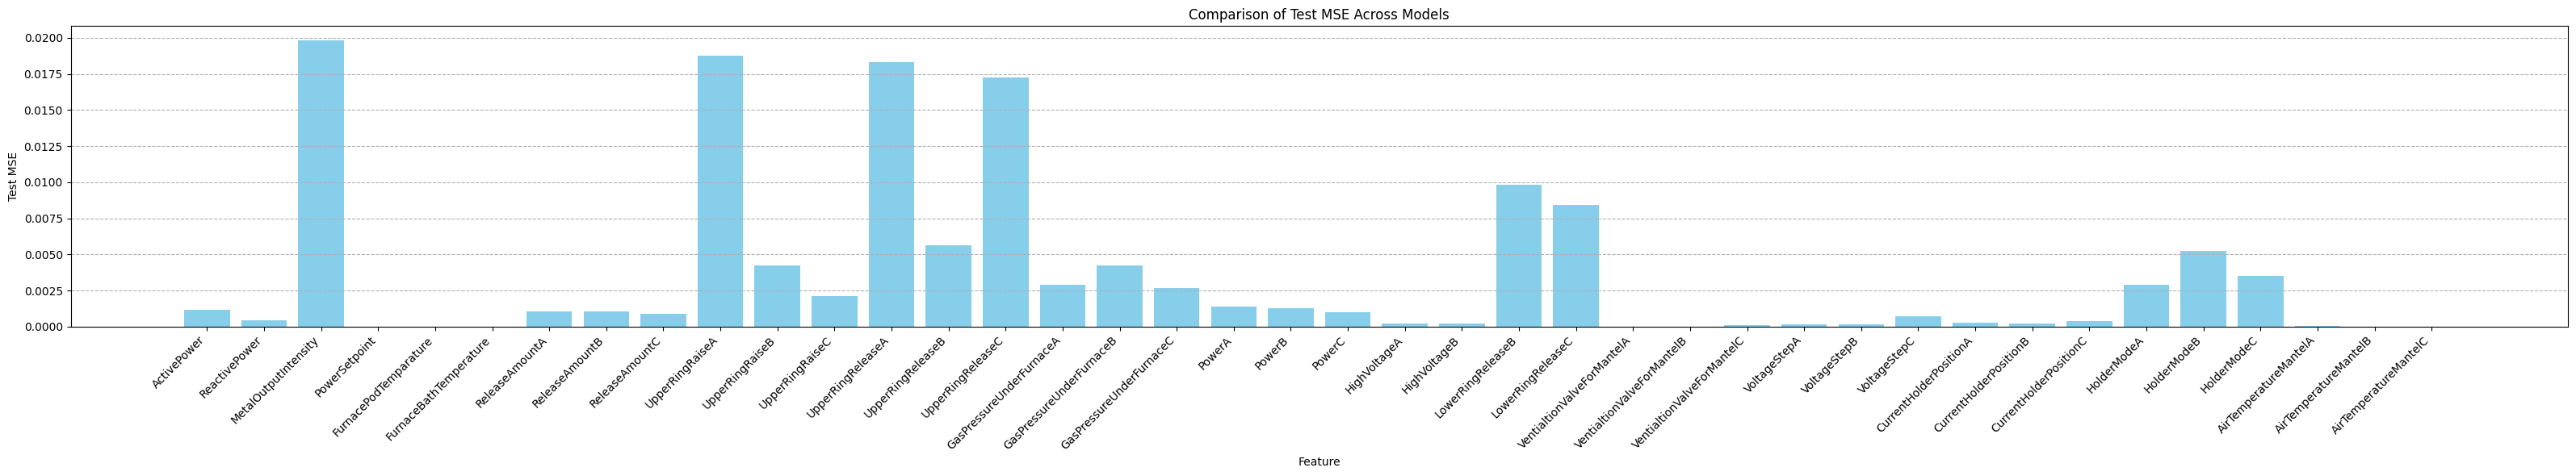

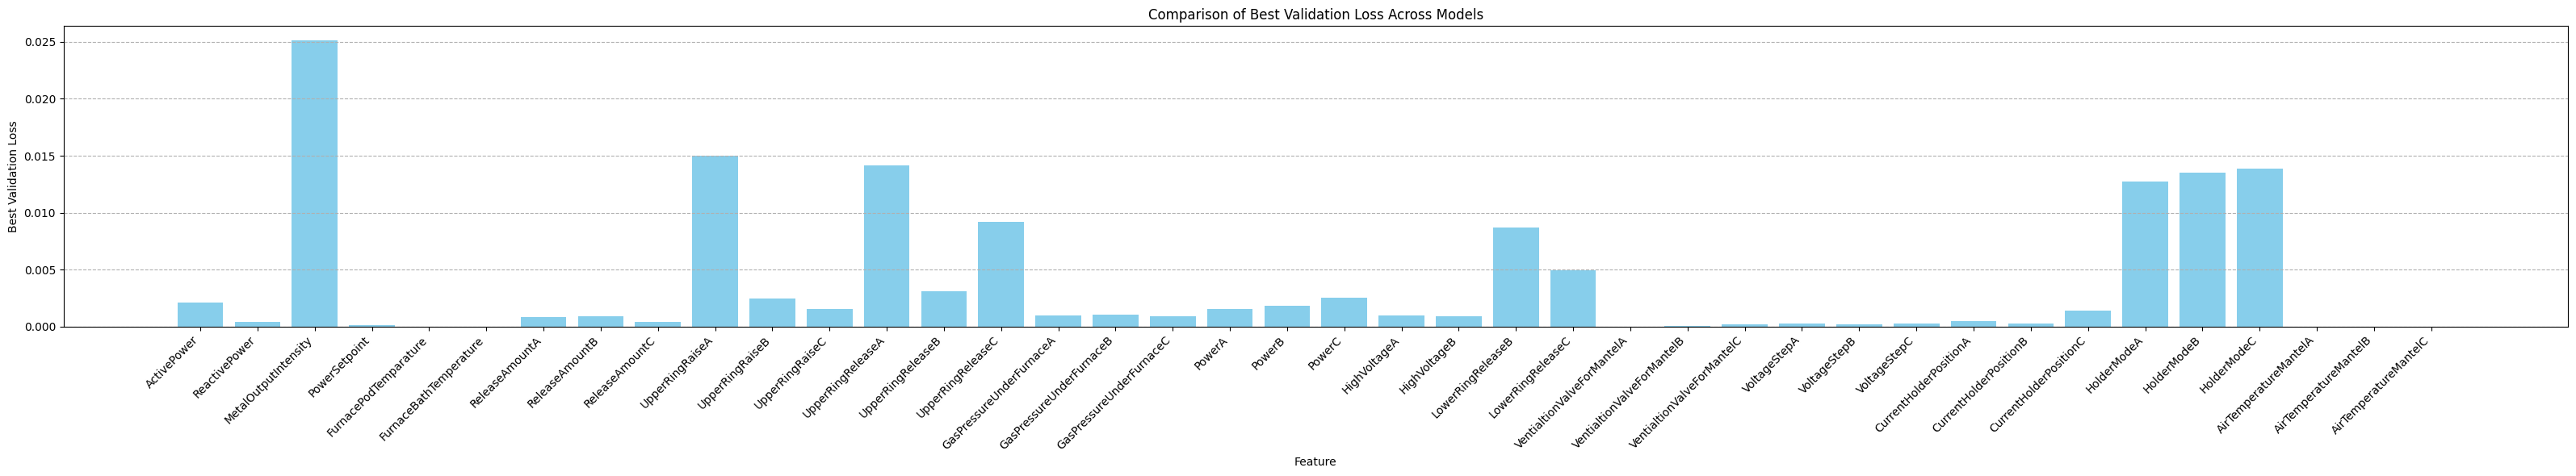

In [17]:
# --- Statistics Visualization ---
print("\n--- Overall Model Performance ---")
if all_test_mses:
    plot_mses = {k: v for k, v in all_test_mses.items() if not np.isnan(v)}
    if plot_mses:
        plot_comparison_metric(
            plot_mses,
            "Test MSE",
            "Comparison of Test MSE Across Models",
            os.path.join(MODEL_EXPORT_BASE_DIR, "comparison_test_mse.png"),
        )
    else:
        print("No valid Test MSEs to plot.")
else:
    print("No Test MSEs recorded.")

if all_best_val_losses:
    plot_val_losses = {k: v for k, v in all_best_val_losses.items() if not np.isnan(v)}
    if plot_val_losses:
        plot_comparison_metric(
            plot_val_losses,
            "Best Validation Loss",
            "Comparison of Best Validation Loss Across Models",
            os.path.join(MODEL_EXPORT_BASE_DIR, "comparison_validation_loss.png"),
        )
    else:
        print("No valid Validation Losses to plot.")

print("\nSummary of Metrics:")
summary_df = pd.DataFrame({
    "Best Train Loss": pd.Series(all_best_train_losses),
    "Best Validation Loss": pd.Series(all_best_val_losses),
    "Test MSE": pd.Series(all_test_mses)
})
print(summary_df.to_string())

summary_csv_path = os.path.join(MODEL_EXPORT_BASE_DIR, "model_metrics_summary.csv")
summary_df.to_csv(summary_csv_path)
print(f"Saved summary metrics to {summary_csv_path}")

print("\nScript finished.")